## Random Forest Regressor (cc exg ch)

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
%matplotlib inline

### load data

In [28]:
with open("./data/train_data/grid_cc.npy", "rb") as fin:
    x_train_grid_cc = np.load(fin)

with open("./data/train_data/grid_exg.npy", "rb") as fin:
    x_train_grid_exg = np.load(fin)
    
with open("./data/train_data/grid_ch.npy", "rb") as fin:
    x_train_grid_ch = np.load(fin)
    
with open("./data/train_data/grid_cv.npy", "rb") as fin:
    x_train_grid_cv = np.load(fin)
    
with open("./data/train_data/yield_train.npy", "rb") as fin:
    y_train = np.load(fin)

In [29]:
print(x_train_grid_cc.shape)
print(x_train_grid_exg.shape)
print(x_train_grid_ch.shape)
print(x_train_grid_cv.shape)
print(y_train.shape)

(7240, 120)
(7240, 120)
(7240, 120)
(7240, 120)
(7240, 1)


In [30]:
with open("./data/test_data/grid_cc.npy", "rb") as fin:
    x_testset_cc = np.load(fin)

with open("./data/test_data/grid_exg.npy", "rb") as fin:
    x_testset_exg = np.load(fin)
    
with open("./data/test_data/grid_ch.npy", "rb") as fin:
    x_testset_ch = np.load(fin)
    
with open("./data/test_data/grid_cv.npy", "rb") as fin:
    x_testset_cv = np.load(fin)
    
with open("./data/test_data/yield_test.npy", "rb") as fin:
    y_testset = np.load(fin)

In [31]:
print(x_testset_cc.shape)
print(x_testset_exg.shape)
print(x_testset_ch.shape)
print(x_testset_cv.shape)
print(y_testset.shape)

(3983, 120)
(3983, 120)
(3983, 120)
(3983, 120)
(3983, 1)


#### yield kg/(100m2) => kg/ha

In [32]:
y_train = y_train / 0.01
y_testset = y_testset / 0.01

### train, validation, and test

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
def split_train_test(x, y, test_size=0.3):
    x_train, x_valid, y_train, y_valid = train_test_split(
        x, y, test_size=test_size, random_state=42
    )
    x_valid, x_test, y_valid, y_test = train_test_split(
        x_valid, y_valid, test_size=0.5, random_state=43
    )
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [35]:
x_train_grid_cc, x_valid_grid_cc, x_test_grid_cc, y_train_grid_cc, y_valid_grid_cc, y_test_grid_cc = split_train_test(x_train_grid_cc, y_train)

In [36]:
x_train_grid_exg, x_valid_grid_exg, x_test_grid_exg, y_train_grid_exg, y_valid_grid_exg, y_test_grid_exg = split_train_test(x_train_grid_exg, y_train)

In [37]:
x_train_grid_ch, x_valid_grid_ch, x_test_grid_ch, y_train_grid_ch, y_valid_grid_ch, y_test_grid_ch = split_train_test(x_train_grid_ch, y_train)

In [38]:
x_train_grid_cv, x_valid_grid_cv, x_test_grid_cv, y_train_grid_cv, y_valid_grid_cv, y_test_grid_cv = split_train_test(x_train_grid_cv, y_train)

In [39]:
all(y_train_grid_cc == y_train_grid_exg), all(y_train_grid_exg == y_train_grid_ch), all(y_train_grid_ch == y_train_grid_cv)

(True, True, True)

In [40]:
all(y_valid_grid_cc == y_valid_grid_exg), all(y_valid_grid_exg == y_valid_grid_ch), all(y_valid_grid_ch == y_valid_grid_cv)

(True, True, True)

In [41]:
all(y_test_grid_cc == y_test_grid_exg), all(y_test_grid_exg == y_test_grid_ch), all(y_test_grid_ch == y_test_grid_cv)

(True, True, True)

In [42]:
y_train = y_train_grid_cc
y_valid = y_valid_grid_cc
y_test = y_test_grid_cc

### rfr

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
max_depth = [6, 8, 16, 20, 30, 40]

#### metrics

In [45]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

#### cc, exg, ch

In [46]:
x_train_cxhv = np.concatenate(
    [x_train_grid_cc, x_train_grid_exg, x_train_grid_ch],
    axis=1,
)

x_train_cxhv.shape, y_train.shape

((5068, 360), (5068, 1))

In [47]:
x_valid_cxhv = np.concatenate(
    [x_valid_grid_cc, x_valid_grid_exg, x_valid_grid_ch],
    axis=1,
)

x_valid_cxhv.shape, y_valid.shape

((1086, 360), (1086, 1))

In [48]:
x_test_cxhv = np.concatenate(
    [x_test_grid_cc, x_test_grid_exg, x_test_grid_ch],
    axis=1,
)

x_test_cxhv.shape, y_test.shape

((1086, 360), (1086, 1))

In [49]:
x_testset_cxhv = np.concatenate(
    [x_testset_cc, x_testset_exg, x_testset_ch],
    axis=1,
)

x_testset_cxhv.shape, y_testset.shape

((3983, 360), (3983, 1))

In [50]:
valid_preds = []
test_preds = []
cross_year_preds = []


for i in max_depth:
    rfr_model = RandomForestRegressor(max_depth=i, random_state=101 + i)
    # preds = rfr_model.fit(x_train_cxhv, np.squeeze(y_train)).predict(x_valid_cxhv)
    rfr_model.fit(x_train_cxhv, np.squeeze(y_train))
    valid_preds.append(rfr_model.predict(x_valid_cxhv))
    test_preds.append(rfr_model.predict(x_test_cxhv))
    cross_year_preds.append(rfr_model.predict(x_testset_cxhv))

In [51]:
# test_preds = []

# for i in max_depth:
#     rfr_model = RandomForestRegressor(max_depth=i, random_state=101+i)
#     preds = rfr_model.fit(x_train_cxhv, np.squeeze(y_train)).predict(x_test_cxhv)
#     test_preds.append(preds)

In [52]:
# cross_year_preds = []

# for i in max_depth:
#     rfr_model = RandomForestRegressor(max_depth=i, random_state=101+i)
#     preds = rfr_model.fit(x_train_cxhv, np.squeeze(y_train)).predict(x_testset_cxhv)
#     cross_year_preds.append(preds)

### valid result summary

In [53]:
for i, valid_pred in enumerate(valid_preds):
    print(f"{max_depth[i]} valid rmse: {np.sqrt(mean_squared_error(y_valid, valid_pred)):.3f}")

6 valid rmse: 144.551
8 valid rmse: 135.734
16 valid rmse: 125.838
20 valid rmse: 125.394
30 valid rmse: 125.986
40 valid rmse: 125.872


In [54]:
for i, valid_pred in enumerate(valid_preds):
    print(f"{max_depth[i]} pearsonr: {pearsonr(np.squeeze(y_valid,-1), valid_pred)[0]:.3f}")

6 pearsonr: 0.912
8 pearsonr: 0.922
16 pearsonr: 0.934
20 pearsonr: 0.934
30 pearsonr: 0.934
40 pearsonr: 0.934


In [55]:
for i, valid_pred in enumerate(valid_preds):
    valid_rmse_p = np.sqrt(mean_squared_error(y_valid, valid_pred)) / np.mean(y_valid)
    print(f"{max_depth[i]} valid rmse%: {valid_rmse_p * 100:.2f}%")

6 valid rmse%: 7.90%
8 valid rmse%: 7.42%
16 valid rmse%: 6.88%
20 valid rmse%: 6.86%
30 valid rmse%: 6.89%
40 valid rmse%: 6.88%


### test result summary

In [56]:
for i, test_pred in enumerate(test_preds):
    print(f"{max_depth[i]} test rmse: {np.sqrt(mean_squared_error(y_test, test_pred)):.3f}")

6 test rmse: 151.237
8 test rmse: 141.867
16 test rmse: 131.399
20 test rmse: 129.847
30 test rmse: 130.199
40 test rmse: 129.838


In [57]:
for i, test_pred in enumerate(test_preds):
    print(f"{max_depth[i]} pearsonr: {pearsonr(np.squeeze(y_test,-1), test_pred)[0]:.3f}")

6 pearsonr: 0.905
8 pearsonr: 0.917
16 pearsonr: 0.929
20 pearsonr: 0.931
30 pearsonr: 0.931
40 pearsonr: 0.931


In [58]:
for i, test_pred in enumerate(test_preds):
    test_rmse_p = np.sqrt(mean_squared_error(y_test, test_pred)) / np.mean(y_test)
    print(f"{max_depth[i]} test rmse%: {test_rmse_p * 100:.2f}%")

6 test rmse%: 8.19%
8 test rmse%: 7.68%
16 test rmse%: 7.12%
20 test rmse%: 7.03%
30 test rmse%: 7.05%
40 test rmse%: 7.03%


### cross year summary

In [59]:
for i, cross_year_pred in enumerate(cross_year_preds):
    print(f"{max_depth[i]} test rmse: {np.sqrt(mean_squared_error(y_testset, cross_year_pred)):.3f}")

6 test rmse: 165.344
8 test rmse: 156.852
16 test rmse: 136.496
20 test rmse: 144.621
30 test rmse: 149.108
40 test rmse: 152.844


In [60]:
for i, cross_year_pred in enumerate(cross_year_preds):
    print(f"{max_depth[i]} pearsonr: {pearsonr(np.squeeze(y_testset,-1), cross_year_pred)[0]:.3f}")

6 pearsonr: 0.746
8 pearsonr: 0.753
16 pearsonr: 0.785
20 pearsonr: 0.769
30 pearsonr: 0.764
40 pearsonr: 0.756


In [61]:
for i, cross_year_pred in enumerate(cross_year_preds):
    cross_year_rmse_p = np.sqrt(mean_squared_error(y_testset, cross_year_pred)) / np.mean(y_testset)
    print(f"{max_depth[i]} test rmse%: {cross_year_rmse_p * 100:.2f}%")

6 test rmse%: 21.46%
8 test rmse%: 20.36%
16 test rmse%: 17.71%
20 test rmse%: 18.77%
30 test rmse%: 19.35%
40 test rmse%: 19.84%


In [65]:
rfr_model = RandomForestRegressor(max_depth=16, random_state=70)

In [66]:
valid_pred = rfr_model.fit(x_train_cxhv, np.squeeze(y_train))

valid_pred = rfr_model.predict(x_valid_cxhv)
test_pred = rfr_model.predict(x_test_cxhv)
cross_year_pred = rfr_model.predict(x_testset_cxhv)

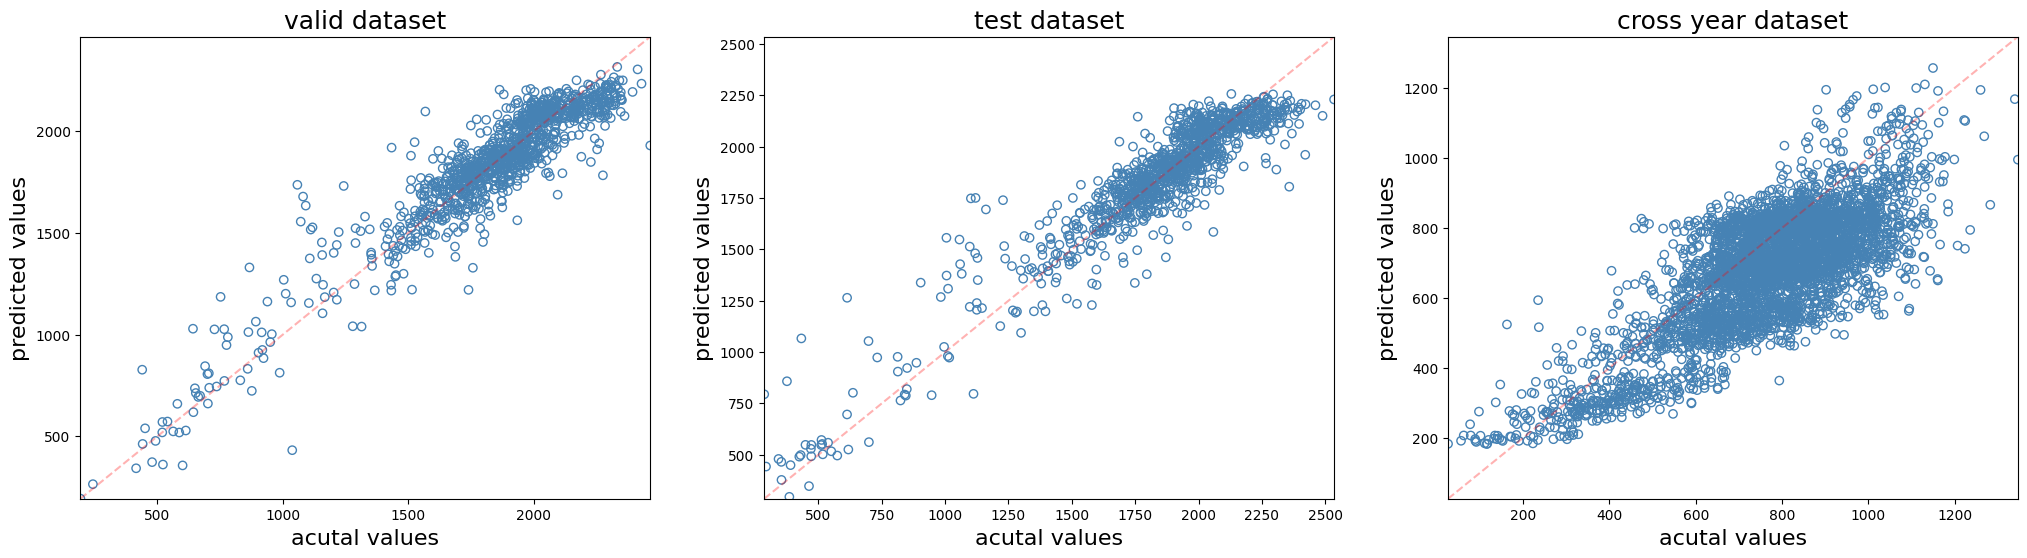

In [67]:
fig, axes = plt.subplots(ncols=3, figsize=(25, 6))

valid_min = np.min([y_valid.min(), valid_pred.min()])
valid_max = np.max([y_valid.max(), valid_pred.max()])
axes[0].scatter(y_valid, valid_pred, facecolors="none", edgecolors="steelblue");
axes[0].set_xlim([valid_min, valid_max])
axes[0].set_ylim([valid_min, valid_max])
axes[0].set_title("valid dataset", fontsize=18);
axes[0].set_xlabel("acutal values", fontsize=16);
axes[0].set_ylabel("predicted values", fontsize=16);
axes[0].plot([valid_min, valid_max], [valid_min, valid_max], linestyle="--", color="red", alpha=0.3);

test_min = np.min([y_test.min(), test_pred.min()])
test_max = np.max([y_test.max(), test_pred.max()])
axes[1].scatter(y_test, test_pred, facecolors="none", edgecolors="steelblue");
axes[1].set_xlim([test_min, test_max])
axes[1].set_ylim([test_min, test_max])
axes[1].set_title("test dataset", fontsize=18);
axes[1].set_xlabel("acutal values", fontsize=16);
axes[1].set_ylabel("predicted values", fontsize=16);
axes[1].plot([test_min, test_max], [test_min, test_max], linestyle="--", color="red", alpha=0.3);

cross_year_min = np.min([y_testset.min(), cross_year_pred.min()])
cross_year_max = np.max([y_testset.max(), cross_year_pred.max()])
axes[2].scatter(y_testset, cross_year_pred, facecolors="none", edgecolors="steelblue");
axes[2].set_xlim([cross_year_min, cross_year_max])
axes[2].set_ylim([cross_year_min, cross_year_max])
axes[2].set_title("cross year dataset", fontsize=18);
axes[2].set_xlabel("acutal values", fontsize=16);
axes[2].set_ylabel("predicted values", fontsize=16);
axes[2].plot([cross_year_min, cross_year_max], [cross_year_min, cross_year_max], linestyle="--", color="red", alpha=0.3);